<a href="https://colab.research.google.com/github/GuiFerreiraS/TCCTrainingImages2/blob/main/Model_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Obtenção das imagens e csv utilizados para treinamento

In [2]:
!git clone https://github.com/GuiFerreiraS/TCCTrainingImages2.git

Cloning into 'TCCTrainingImages2'...
remote: Enumerating objects: 19303, done.
remote: Total 19303 (delta 0), reused 0 (delta 0), pack-reused 19303
Receiving objects: 100% (19303/19303), 285.16 MiB | 13.83 MiB/s, done.
Checking out files: 100% (19300/19300), done.


In [3]:
!ls TCCTrainingImages2

driving_log.csv  IMG


###Importação das bibliotecas utilizadas

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
from google.colab import files

###Tratamento dos dados do csv

In [5]:
datadir = 'TCCTrainingImages2'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...      speed
0  C:\Users\guilh\Desktop\Gravacao_02\IMG\center_2021_09_30_21_22_04_081.jpg  ...  9.507993 
1  C:\Users\guilh\Desktop\Gravacao_02\IMG\center_2021_09_30_21_22_04_194.jpg  ...  10.839280
2  C:\Users\guilh\Desktop\Gravacao_02\IMG\center_2021_09_30_21_22_04_306.jpg  ...  12.066140
3  C:\Users\guilh\Desktop\Gravacao_02\IMG\center_2021_09_30_21_22_04_417.jpg  ...  13.116280
4  C:\Users\guilh\Desktop\Gravacao_02\IMG\center_2021_09_30_21_22_04_524.jpg  ...  14.131230

[5 rows x 7 columns]

In [6]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...      speed
0  center_2021_09_30_21_22_04_081.jpg  ...  9.507993 
1  center_2021_09_30_21_22_04_194.jpg  ...  10.839280
2  center_2021_09_30_21_22_04_306.jpg  ...  12.066140
3  center_2021_09_30_21_22_04_417.jpg  ...  13.116280
4  center_2021_09_30_21_22_04_524.jpg  ...  14.131230

[5 rows x 7 columns]

###Descartando parte dos dados 
É necessario descartar parte dos dados em que o carro dirige em linha reta para evitar um overtraining que possa gerar uma tendencia do carro não virar nas curvas

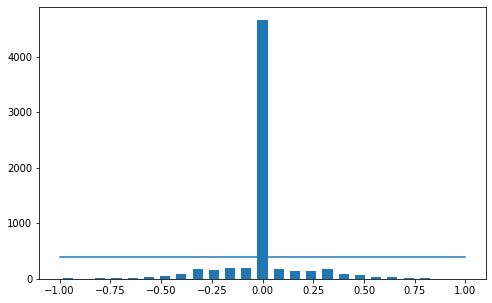

In [7]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5

plt.rcParams["figure.figsize"] = (8,5)

plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data 6433
removed 4261
remaining 2172


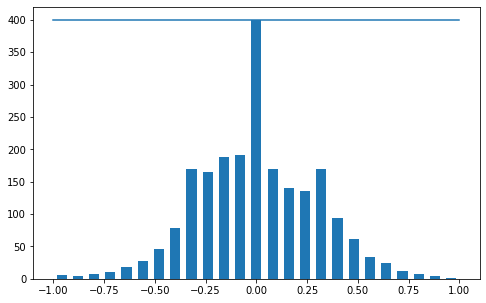

In [8]:
print('total data', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

###Carregamento dos das imagens centrais e dos dados de direção
As imagens centrais e os dados da direção do carro são colocados em seus respectivos arrays

In [9]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, _, _ = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

###Separação dos dados de treinamento e validação

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1737
Valid Samples: 435


Text(0.5, 1.0, 'Valid set')

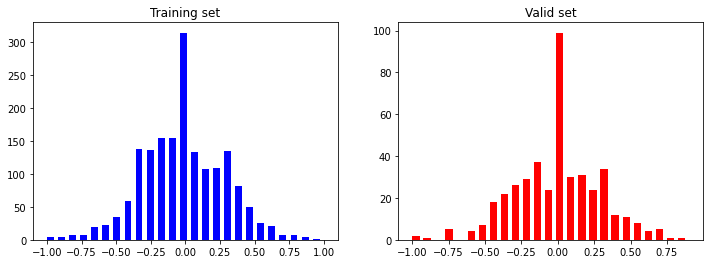

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Valid set')

###Augment
#####Funções utilizadas para fazer pequenas alterações nas imagens existentes, aumentando a base de dados para treinamento

####Função de zoom
Cria um zoom aleatorio aumentando a imagem em até 30%

In [12]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed image')

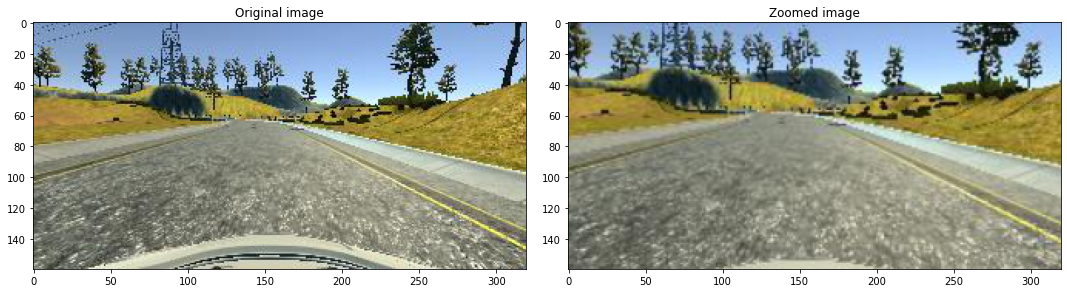

In [13]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed image')

####Função de translação
Consiste  em  mover  a  imagem  no  máximo10 % no eixo x ou y

In [14]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x" : (-0.1, 0.1), "y" : (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned image')

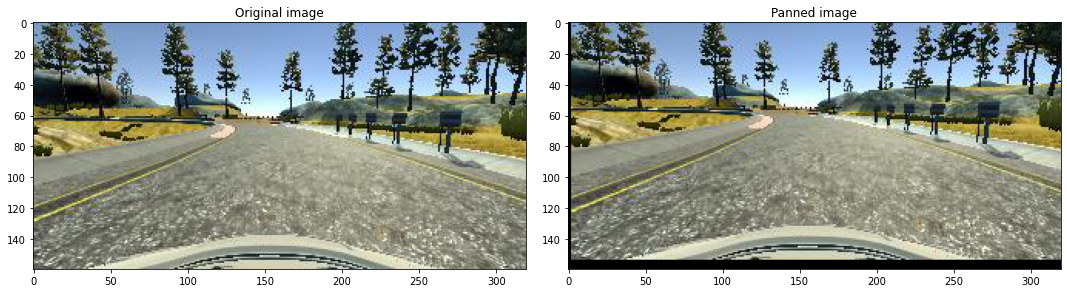

In [15]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned image')

####Função de mudança de brilho
Muda o brilho da imagem em até 20% 

In [16]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness altered image')

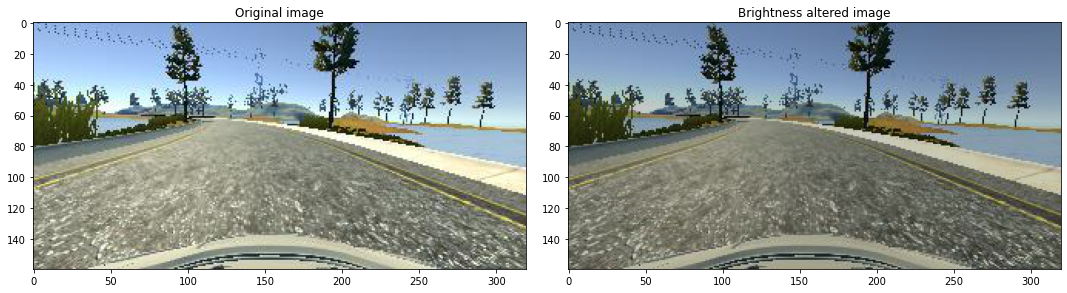

In [17]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image')

####Função de espelhamento
Faz o espelhamento da imagem e do angulo da direção

In [18]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped altered image - Steering angle0.07482269999999999')

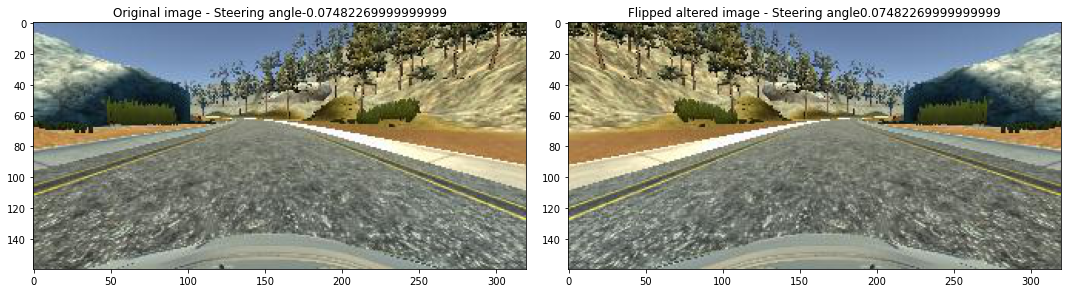

In [19]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image - Steering angle' + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped altered image - Steering angle' + str(flipped_steering_angle))

####Função de geração de sombras
Cria uma sombra aleatoria na imagem

In [20]:
def generate_shadow_coordinates(imshape):
  vertex=[]
  for dimensions in range(4):
    if dimensions < 2:
      vertex.append(( imshape[1]*np.random.uniform(), 0))
    else:
      vertex.append(( imshape[1]*np.random.uniform(), 160))
  vertices = np.array([vertex], dtype=np.int32) 
  return vertices 

In [21]:
def shadow(image):
  image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) 
  mask = np.zeros_like(image)
  imshape = image.shape
  vertices_list= generate_shadow_coordinates(imshape) 
  for vertices in vertices_list:
    cv2.fillPoly(mask, np.int32(vertices_list) , 255) 
  image_HLS[:,:,1][mask[:,:,0]==255] = image_HLS[:,:,1][mask[:,:,0]==255]*random.uniform(0.25, 0.4)   
  image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) 
  return image_RGB

Text(0.5, 1.0, 'Image with shadow')

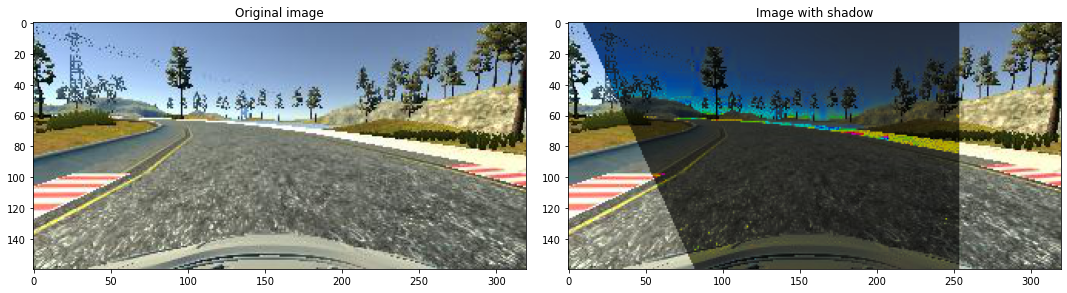

In [22]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
shadow_image = shadow(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(shadow_image)
axs[1].set_title('Image with shadow')

####Combinação aleatoria das mudanças nas imagens
Cria uma combinação aleatoria de mudanças na imagem

In [23]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  if np.random.rand() < 0.5:
    image = shadow(image)

  return image, steering_angle

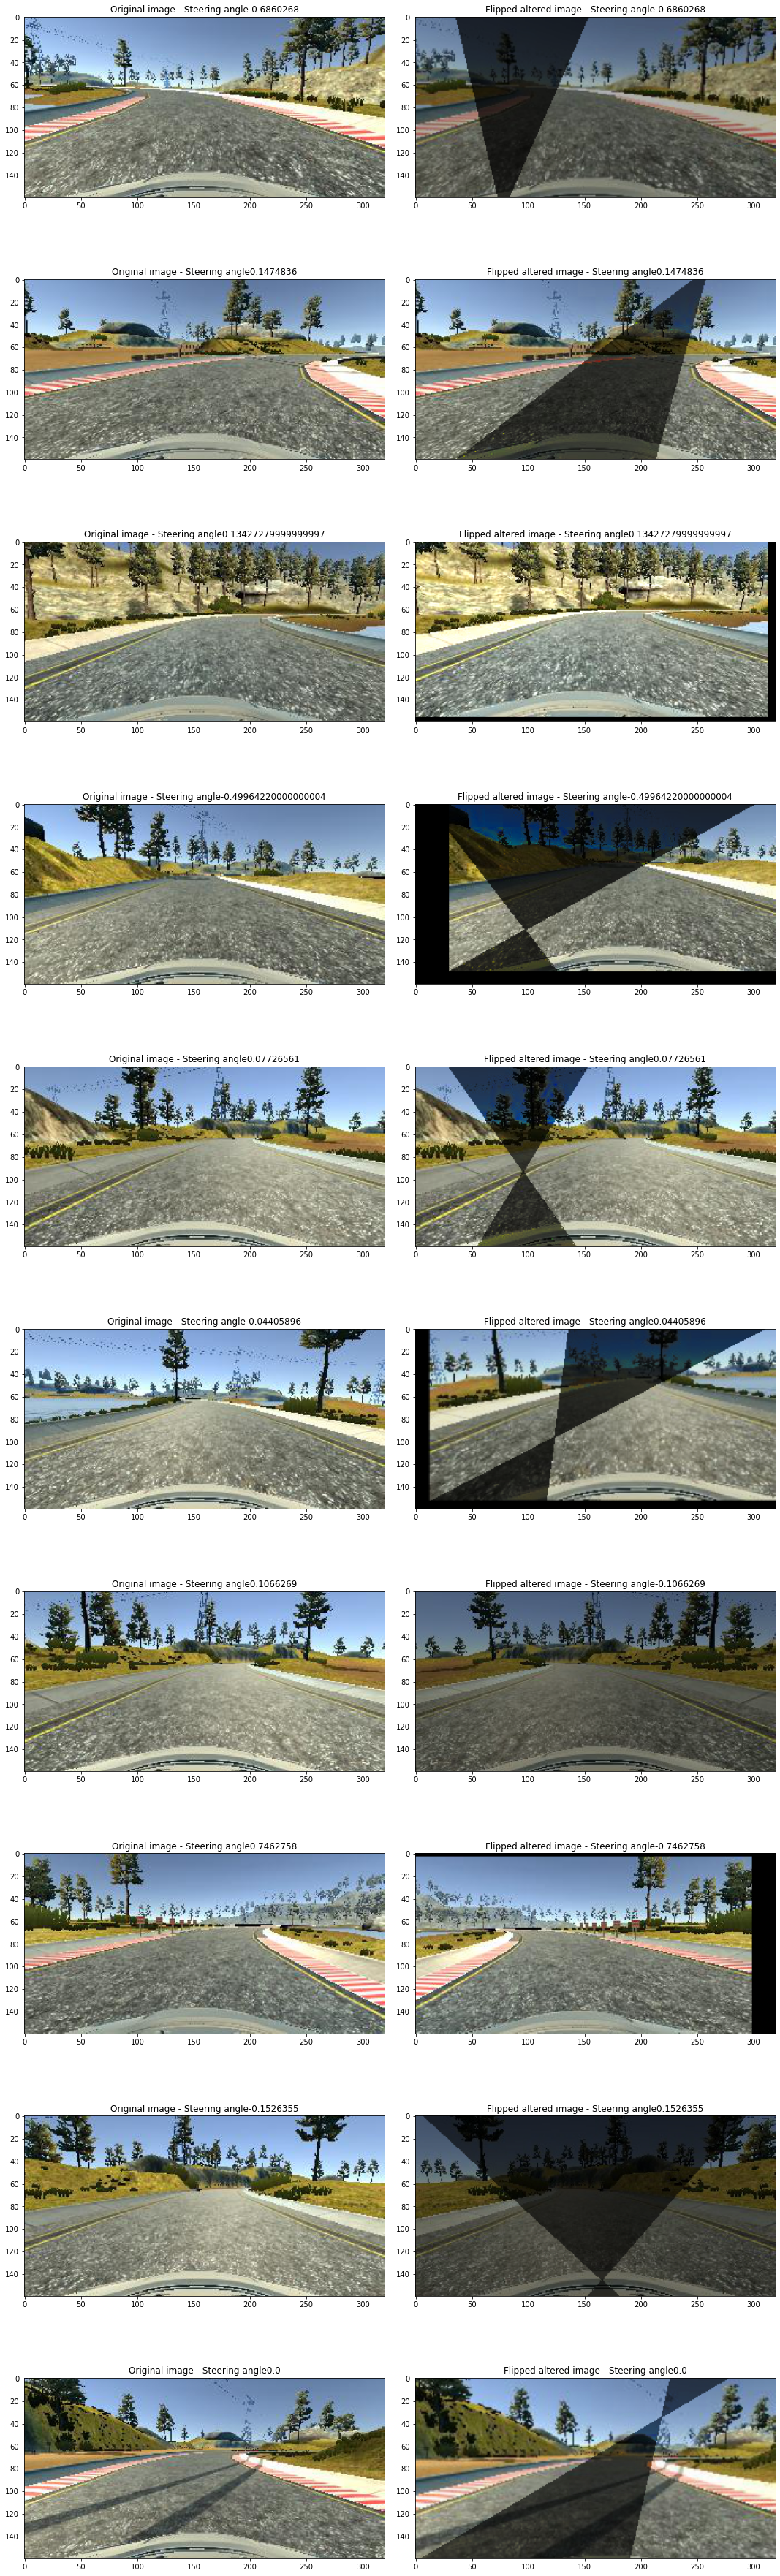

In [24]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original image - Steering angle' + str(random_steering))
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Flipped altered image - Steering angle' + str(steering))


###Pré-processamento das imagens
Recorta apenas a região de interesse da imagem, muda o padrão de cores, adiciona um blur e normaliza as imagens

In [25]:
def img_preprocess(img):
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3 ,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

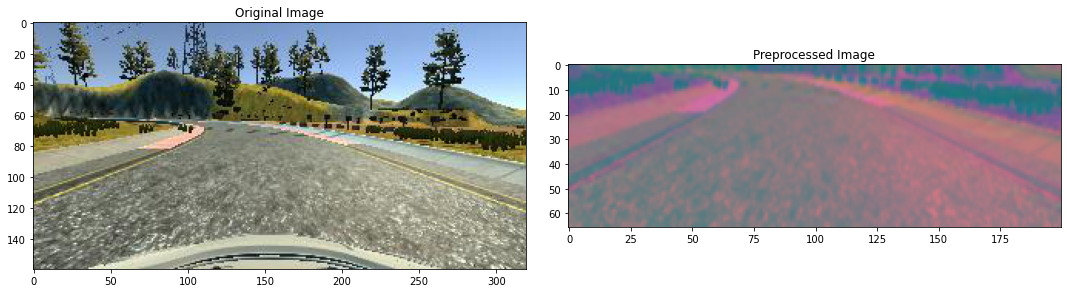

In [26]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

###Função de geração de imagens
Utiliza as funções acima para aumentar a quantidade de dados de treinamento e aplica o processamento das imagens 

In [27]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation image')

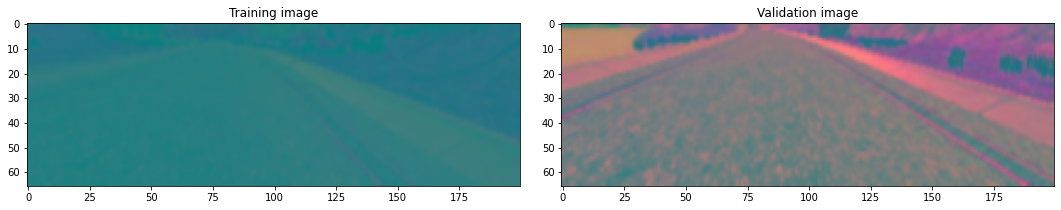

In [28]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training image')
axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Validation image')

###Criação do modelo de treinamento
Define as camadas da CNN com base no artigo https://arxiv.org/pdf/1604.07316.pdf

In [29]:
def nvidia_model():
  model = Sequential()
  
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
  
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  # model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  # model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  # model.add(Dropout(0.5))
  model.add(Dense(10, activation='elu'))
  # model.add(Dropout(0.5))
  model.add(Dense(1))
  
  
  optimizer = Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
 
  return model

In [30]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

####Download do fluxograma da estrutura da rede

In [32]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)

files.download('model.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Treinamento do modelo

In [ ]:
h = model.fit(batch_generator(X_train, y_train, 100, 1), steps_per_epoch=300, epochs=10, validation_data = batch_generator(X_valid, y_valid, 100, 0), validation_steps=200, verbose=1, shuffle=1)

Epoch 1/10
 32/300 [==>...........................] - ETA: 2:57 - loss: 0.3600

KeyboardInterrupt: ignored

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

###Download do modelo

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')